# Alunos
* Arthur Severo
* Victor Le Roy

## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [56]:
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [57]:
## Import Keras objects for Deep Learning

from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam


In [58]:
## Load in the data set (Internet Access needed)

##url = "http://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv('data/pima-indians-diabetes.data', names=names)

In [59]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
539,3,129,92,49,155,36.4,0.968,32,1
502,6,0,68,41,0,39.0,0.727,41,1
715,7,187,50,33,392,33.9,0.826,34,1
96,2,92,62,28,0,31.6,0.130,24,0
302,5,77,82,41,42,35.8,0.156,35,0


In [60]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [61]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [62]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [63]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [64]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)





print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.766
roc-auc is 0.825


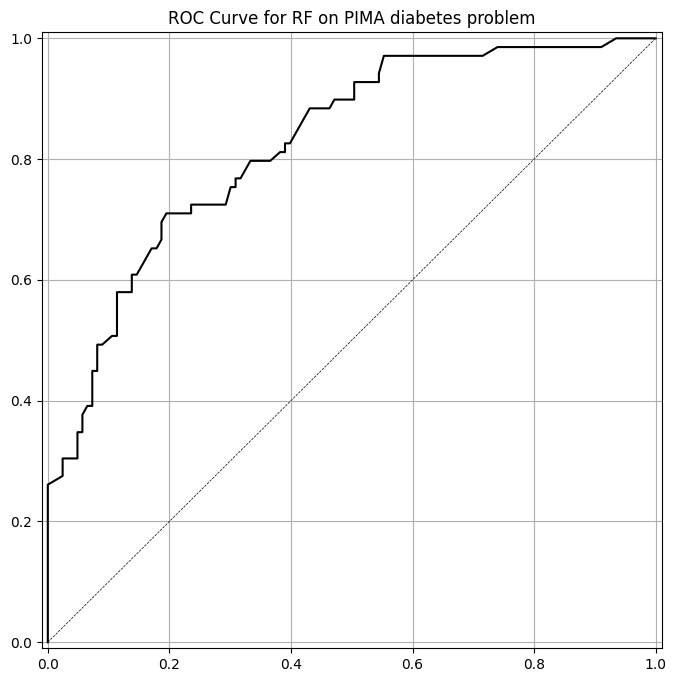

In [65]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])


plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.

In [66]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications


normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [67]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential([
    Dense(12, input_shape=(8,), activation="relu"),
    Dense(1, activation="sigmoid")
])

In [68]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 12)                108       
                                                                 
 dense_17 (Dense)            (None, 1)                 13        
                                                                 
Total params: 121 (484.00 Byte)
Trainable params: 121 (484.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Comprehension question:
Why do we have 121 parameters?  Does that make sense?


Let's fit our model for 200 epochs.

In [69]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Epoch 1/200
18/18 [==============================] - 0s 7ms/step - loss: 0.7307 - accuracy: 0.5642 - val_loss: 0.7166 - val_accuracy: 0.5833
Epoch 2/200
18/18 [==============================] - 0s 2ms/step - loss: 0.7141 - accuracy: 0.5851 - val_loss: 0.7015 - val_accuracy: 0.5833
Epoch 3/200
18/18 [==============================] - 0s 2ms/step - loss: 0.6995 - accuracy: 0.5938 - val_loss: 0.6882 - val_accuracy: 0.5781
Epoch 4/200
18/18 [==============================] - 0s 2ms/step - loss: 0.6867 - accuracy: 0.6024 - val_loss: 0.6764 - val_accuracy: 0.5938
Epoch 5/200
18/18 [==============================] - 0s 2ms/step - loss: 0.6752 - accuracy: 0.6181 - val_loss: 0.6659 - val_accuracy: 0.5990
Epoch 6/200
18/18 [==============================] - 0s 2ms/step - loss: 0.6646 - accuracy: 0.6302 - val_loss: 0.6565 - val_accuracy: 0.6198
Epoch 7/200
18/18 [==============================] - 0s 2ms/step - loss: 0.6553 - accuracy: 0.6424 - val_loss: 0.6479 - val_accuracy: 0.6094
Epoch 8/200
1

<span style="color:red"> Respostas: </span>

Faz sentido os 121 parametros, isto pois faz sentido pois a saída de uma camada é a entrada da outra depois dela.

* Como o input da primeira camada é 8 e sua saída é 12 --> dense = 12*(8+1->bias) = 108.
* Como o input da segunda camada é a saída da primeira (12) --> dense_1 = 1*(12+1 -> bias) = 13.

Logo, dense + dense_1 = 121.



In [70]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

#y_pred_class_nn_1 = model_1.predict_classes(X_test_norm)
#y_pred_prob_nn_1 = model_1.predict(X_test_norm)

y_pred_prob_nn_1 = model_1.predict(X_test_norm)
y_pred_class_nn_1 = (y_pred_prob_nn_1 > 0.5).astype("int32")

#O método "predict_classes" não funciona nas versões do Keras superior a 2.5 

# A indicação da correção se encontra em https://keras.rstudio.com/reference/predict_proba.html#details. 



1/6 [====>.........................] - ETA: 0s

6/6 [==============================] - 0s 800us/step


In [71]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0]])

In [72]:
y_pred_prob_nn_1[:10]

array([[0.5995791 ],
       [0.7200159 ],
       [0.3151101 ],
       [0.2830642 ],
       [0.20483905],
       [0.5510881 ],
       [0.03004153],
       [0.3427856 ],
       [0.8431037 ],
       [0.16882934]], dtype=float32)

accuracy is 0.750
roc-auc is 0.821


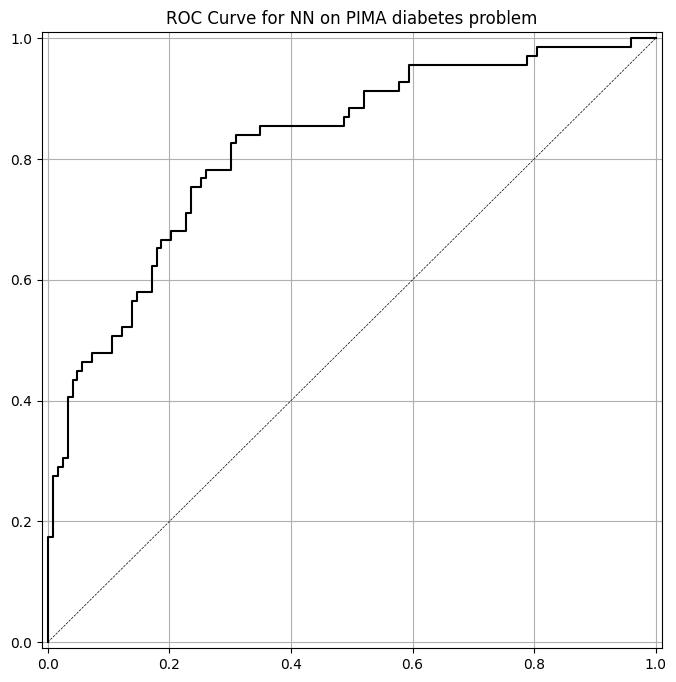

In [73]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [74]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

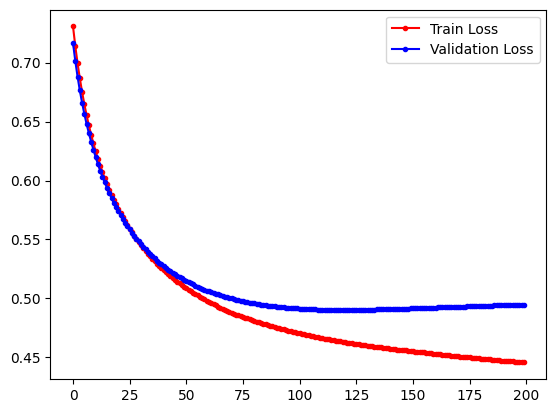

In [75]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.

In [76]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Epoch 1/1000
 1/18 [>.............................] - ETA: 0s - loss: 0.3834 - accuracy: 0.8438

18/18 [==============================] - 0s 3ms/step - loss: 0.4455 - accuracy: 0.7899 - val_loss: 0.4946 - val_accuracy: 0.7500
Epoch 2/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4454 - accuracy: 0.7917 - val_loss: 0.4947 - val_accuracy: 0.7500
Epoch 3/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4452 - accuracy: 0.7882 - val_loss: 0.4947 - val_accuracy: 0.7500
Epoch 4/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4451 - accuracy: 0.7917 - val_loss: 0.4947 - val_accuracy: 0.7500
Epoch 5/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4450 - accuracy: 0.7899 - val_loss: 0.4948 - val_accuracy: 0.7500
Epoch 6/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4448 - accuracy: 0.7899 - val_loss: 0.4948 - val_accuracy: 0.7500
Epoch 7/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4446 - accuracy: 0.7899 - val_loss: 0.4949 - val_accuracy: 0.7500
Epoch 8/1000
18/18 

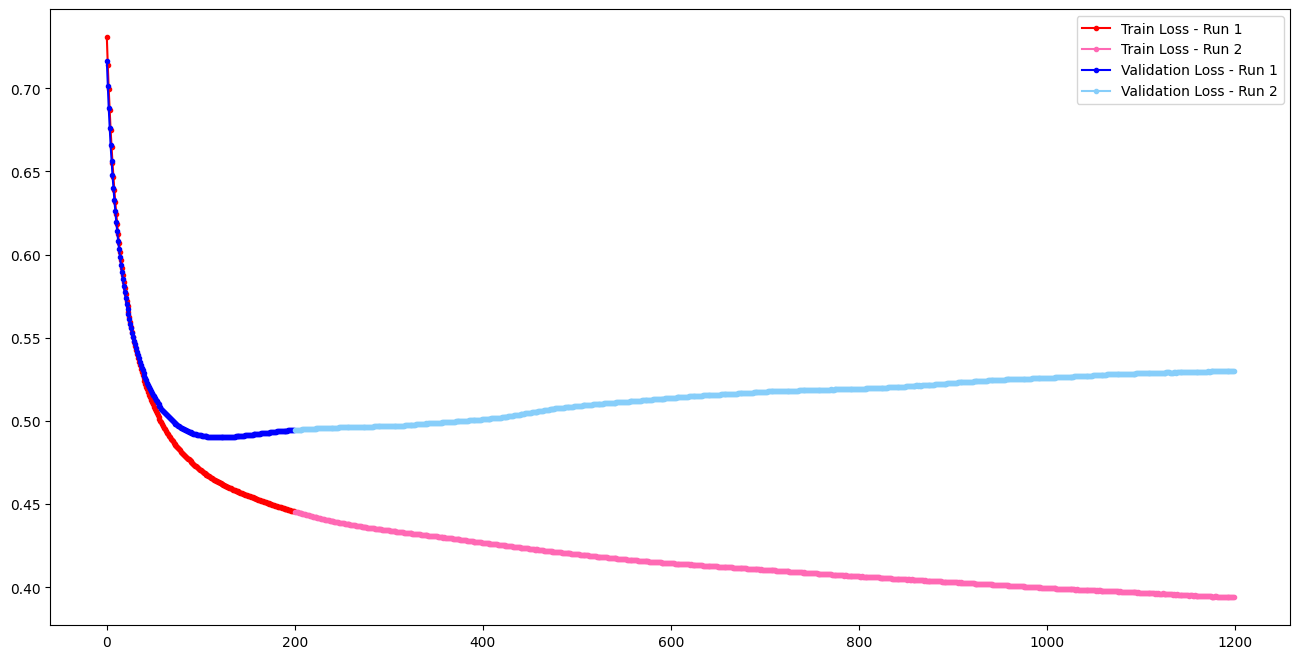

In [77]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

<span style="color:red"> Respostas: </span>

O melhor número de épocas é por volta de 200, pois a partir deste valor, apesar de o erro de treino continuar a diminuir, o erro de validação começa a aumentar.
Isto provavelmente faz com que o modelo comece a fazer overfitting.

Uma outra forma de garantir o número adequado para as épocas é utilizar o EarlyStopping, que verifica a cada, por exemplo, 10 iterações se o valor do erro aumentou.
Caso tenha aumentado, o treino é interrompido.

Epoch 1/1000
18/18 [==============================] - 0s 6ms/step - loss: 0.8545 - accuracy: 0.3976 - val_loss: 0.8422 - val_accuracy: 0.4583
Epoch 2/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.8194 - accuracy: 0.4167 - val_loss: 0.8091 - val_accuracy: 0.4583
Epoch 3/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.7891 - accuracy: 0.4410 - val_loss: 0.7807 - val_accuracy: 0.5000
Epoch 4/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.7630 - accuracy: 0.4913 - val_loss: 0.7560 - val_accuracy: 0.5156
Epoch 5/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.7405 - accuracy: 0.5365 - val_loss: 0.7345 - val_accuracy: 0.5885
Epoch 6/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.7209 - accuracy: 0.5938 - val_loss: 0.7157 - val_accuracy: 0.6146
Epoch 7/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.7035 - accuracy: 0.6372 - val_loss: 0.6989 - val_accuracy: 0.6562
Epoch 

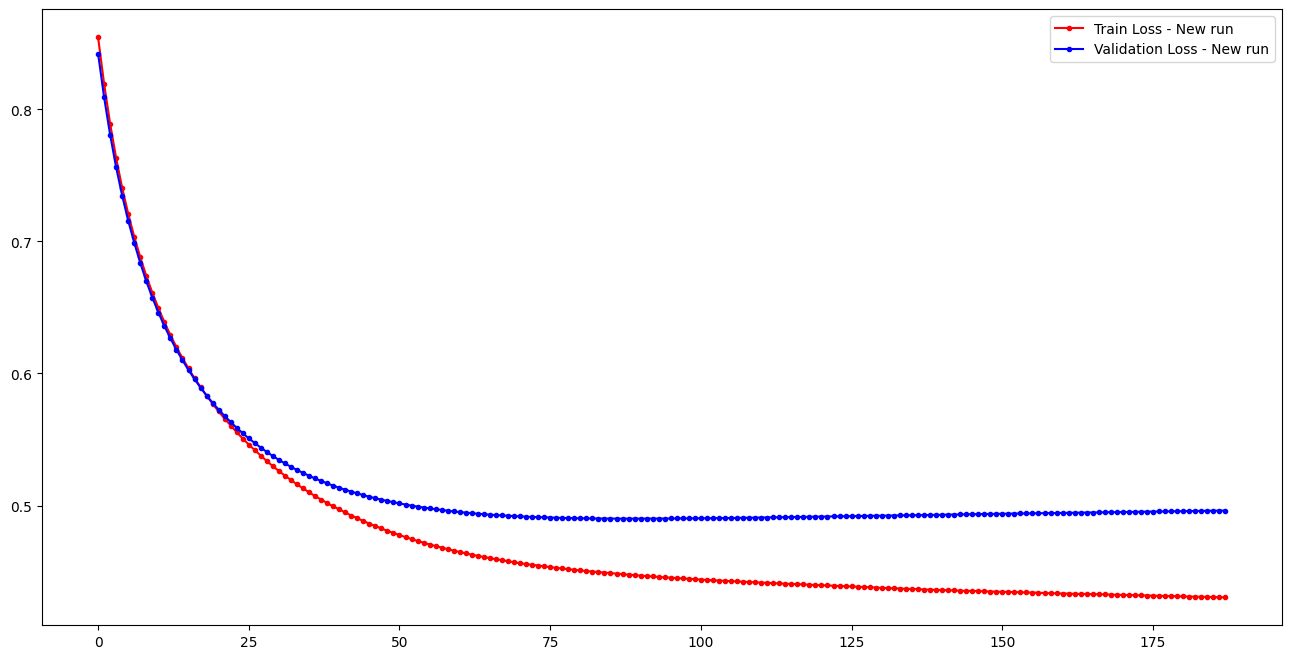

In [78]:
from keras import callbacks
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor ="val_loss", mode = 'min', patience=100, verbose = 1)

model_1 = Sequential([
    Dense(12, input_shape=(8,), activation="relu"),
    Dense(1, activation="sigmoid")
])
model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1_NEW = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000, callbacks =[earlystopping])

n = len(run_hist_1_NEW.history["loss"])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1_NEW.history["loss"],'r', marker='.', label="Train Loss - New run")
ax.plot(range(n), run_hist_1_NEW.history["val_loss"],'b', marker='.', label="Validation Loss - New run")

ax.legend()

## Exercise
Now it's your turn.  Do the following in the cells below:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 1500 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures

In [97]:
normalizer = StandardScaler()
X_train_norm_exercise = normalizer.fit_transform(X_train)
X_test_norm_exercise = normalizer.transform(X_test)

model_exercise = Sequential([
    Dense(6, input_shape=(8,), activation="relu"),
    Dense(6, activation="relu"),
    Dense(1, activation="sigmoid")
])
model_exercise.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 6)                 54        
                                                                 
 dense_27 (Dense)            (None, 6)                 42        
                                                                 
 dense_28 (Dense)            (None, 1)                 7         
                                                                 
Total params: 103 (412.00 Byte)
Trainable params: 103 (412.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [99]:
from matplotlib.pyplot import figure

def plotarGraficos(structure,run_hist, y_pred_class, y_pred_prob):
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    ax.plot(run_hist.history["loss"],'r', marker='.', label="Train Loss")
    ax.plot(run_hist.history["val_loss"],'b', marker='.', label="Validation Loss")
    ax.plot(run_hist.history["accuracy"],'g', marker='.', label="Accuracy")
    ax.plot(run_hist.history["val_accuracy"],'y', marker='.', label="val_Accuracy")
    ax.legend()

    # Plot the roc curve for the predictions
    print(f'{structure} '+'accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class)))
    print(f'{structure} '+'roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob)))
    fig.savefig(f'{structure}.png', dpi=100)
    plot_roc(y_test, y_pred_prob, 'NN')

Epoch 1/1500


18/18 [==============================] - 0s 6ms/step - loss: 0.2179 - accuracy: 0.6441 - val_loss: 0.2258 - val_accuracy: 0.5938
Epoch 2/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.2173 - accuracy: 0.6545 - val_loss: 0.2252 - val_accuracy: 0.6094
Epoch 3/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.2167 - accuracy: 0.6580 - val_loss: 0.2247 - val_accuracy: 0.6146
Epoch 4/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.2161 - accuracy: 0.6615 - val_loss: 0.2242 - val_accuracy: 0.6042
Epoch 5/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.2155 - accuracy: 0.6580 - val_loss: 0.2237 - val_accuracy: 0.6042
Epoch 6/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.2149 - accuracy: 0.6510 - val_loss: 0.2233 - val_accuracy: 0.6094
Epoch 7/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.2144 - accuracy: 0.6528 - val_loss: 0.2228 - val_accuracy: 0.6094
Epoch 8/1500
18/18 

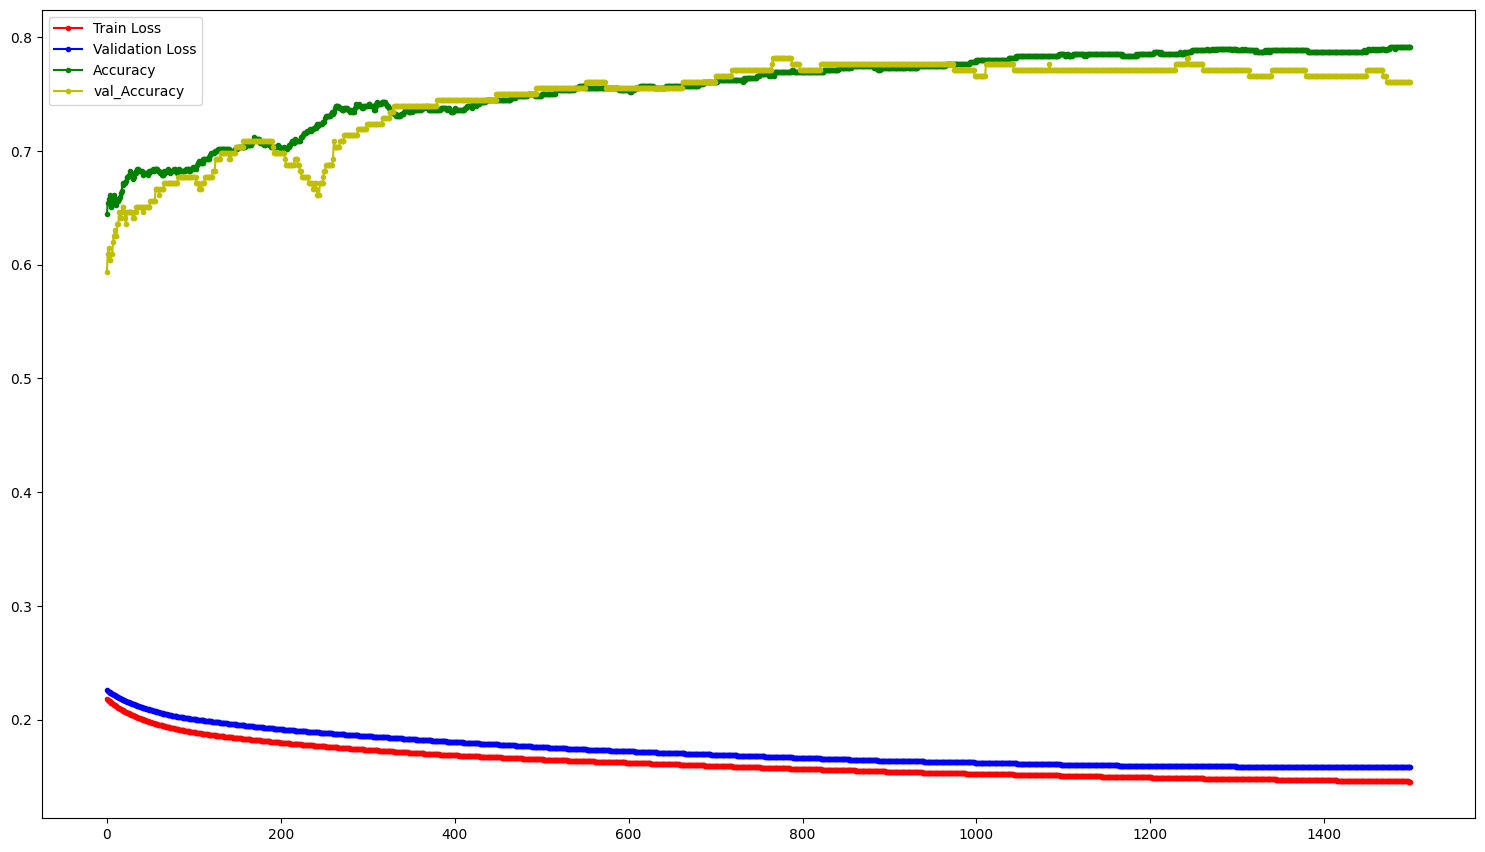

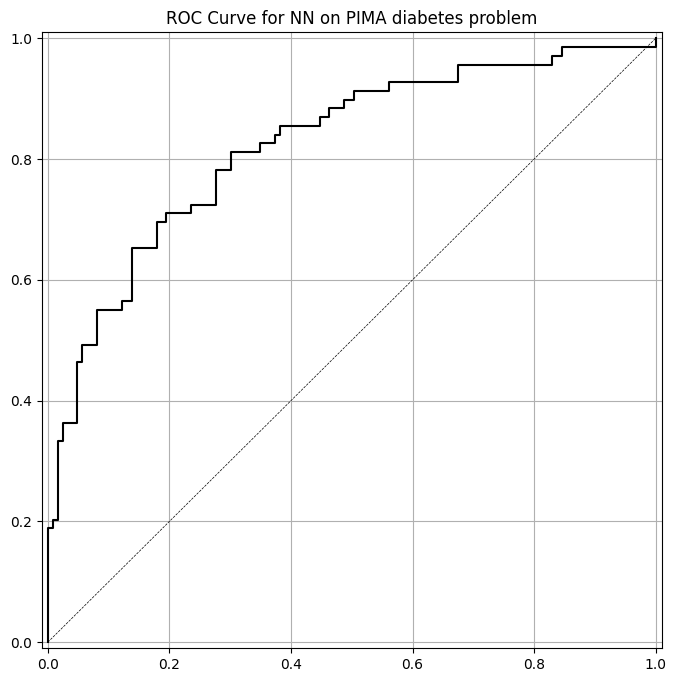

In [100]:
## usando taxa de aprendizado de .003 e treinando por 1500 epocas com o SGD.
model_exercise.compile(SGD(learning_rate = 0.003), "mse", metrics=["accuracy"])
run_hist_ex = model_exercise.fit(X_train_norm_exercise, y_train, validation_data=(X_test_norm_exercise, y_test), epochs=1500)

y_pred_prob_nn_1_ex = model_exercise.predict(X_test_norm_exercise)
y_pred_class_nn_1_ex = (y_pred_prob_nn_1_ex > 0.5).astype("int32")
y_pred_class_nn_1_ex[:10]
y_pred_prob_nn_1_ex[:10]

plotarGraficos('estrutura SGD tx=0.003, 1500 epocas',run_hist_ex,y_pred_class_nn_1_ex,y_pred_prob_nn_1_ex)

Epoch 1/500
18/18 [==============================] - 0s 7ms/step - loss: 0.1459 - accuracy: 0.7917 - val_loss: 0.1587 - val_accuracy: 0.7604
Epoch 2/500
18/18 [==============================] - 0s 2ms/step - loss: 0.1458 - accuracy: 0.7934 - val_loss: 0.1588 - val_accuracy: 0.7656
Epoch 3/500
18/18 [==============================] - 0s 2ms/step - loss: 0.1456 - accuracy: 0.7951 - val_loss: 0.1588 - val_accuracy: 0.7656
Epoch 4/500
18/18 [==============================] - 0s 2ms/step - loss: 0.1454 - accuracy: 0.7899 - val_loss: 0.1589 - val_accuracy: 0.7604
Epoch 5/500
18/18 [==============================] - 0s 2ms/step - loss: 0.1454 - accuracy: 0.7951 - val_loss: 0.1589 - val_accuracy: 0.7656
Epoch 6/500
18/18 [==============================] - 0s 2ms/step - loss: 0.1451 - accuracy: 0.7951 - val_loss: 0.1590 - val_accuracy: 0.7604
Epoch 7/500
18/18 [==============================] - 0s 2ms/step - loss: 0.1449 - accuracy: 0.7934 - val_loss: 0.1591 - val_accuracy: 0.7552
Epoch 8/500
1

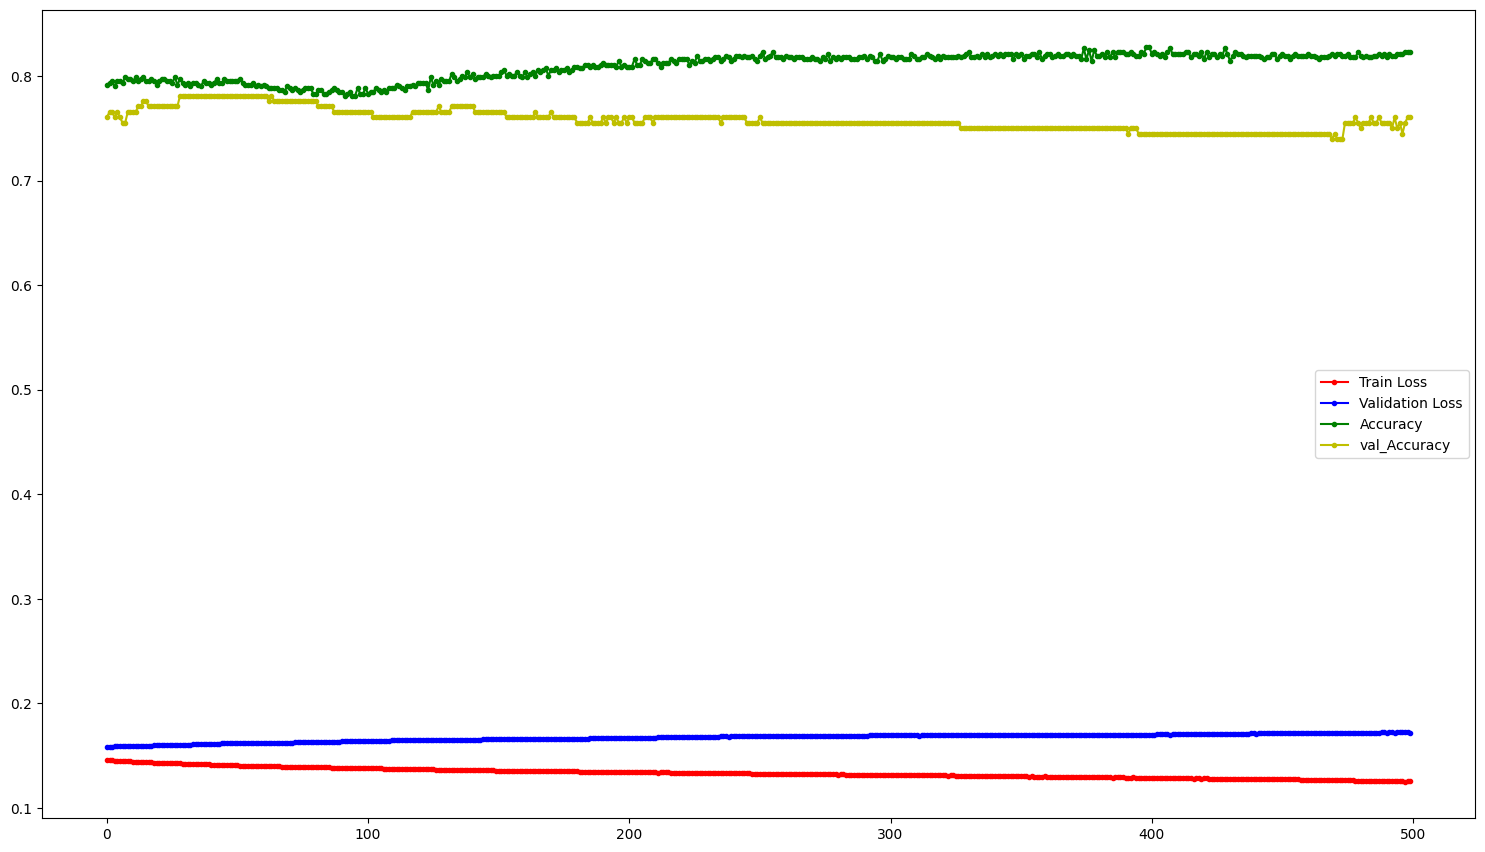

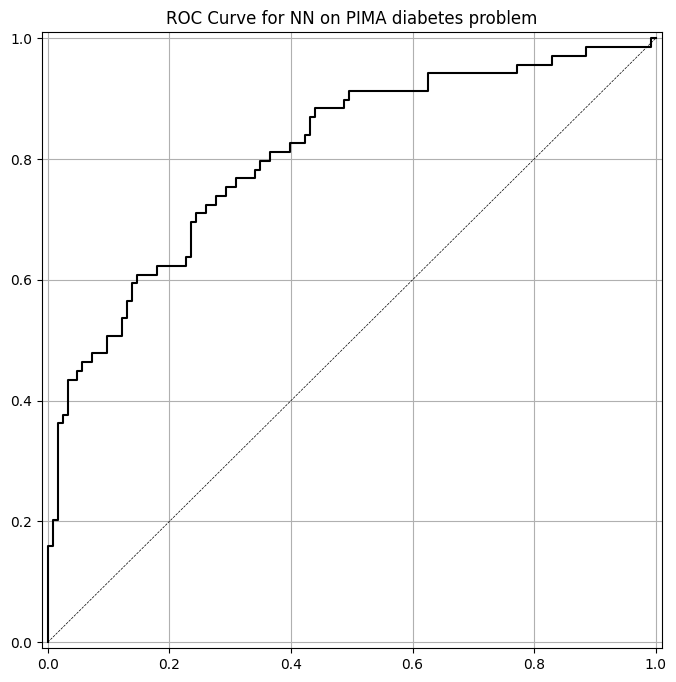

In [101]:
## usando taxa de aprendizado de .05 e treinando por 500 epocas com o SGD.
model_exercise.compile(SGD(learning_rate = 0.05), "mse", metrics=["accuracy"])
run_hist_ex = model_exercise.fit(X_train_norm_exercise, y_train, validation_data=(X_test_norm_exercise, y_test), epochs=500)

y_pred_prob_nn_1_ex = model_exercise.predict(X_test_norm_exercise)
y_pred_class_nn_1_ex = (y_pred_prob_nn_1_ex > 0.5).astype("int32")
y_pred_class_nn_1_ex[:10]
y_pred_prob_nn_1_ex[:10]

plotarGraficos('estrutura SGD tx=0.003, 1500 epocas',run_hist_ex,y_pred_class_nn_1_ex,y_pred_prob_nn_1_ex)

Epoch 1/1500


18/18 [==============================] - 0s 6ms/step - loss: 0.1264 - accuracy: 0.8194 - val_loss: 0.1726 - val_accuracy: 0.7500
Epoch 2/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.1260 - accuracy: 0.8264 - val_loss: 0.1728 - val_accuracy: 0.7448
Epoch 3/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.1253 - accuracy: 0.8247 - val_loss: 0.1721 - val_accuracy: 0.7604
Epoch 4/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.1250 - accuracy: 0.8229 - val_loss: 0.1723 - val_accuracy: 0.7604
Epoch 5/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.1246 - accuracy: 0.8264 - val_loss: 0.1736 - val_accuracy: 0.7448
Epoch 6/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.1243 - accuracy: 0.8229 - val_loss: 0.1731 - val_accuracy: 0.7500
Epoch 7/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.1242 - accuracy: 0.8247 - val_loss: 0.1733 - val_accuracy: 0.7500
Epoch 8/1500
18/18 

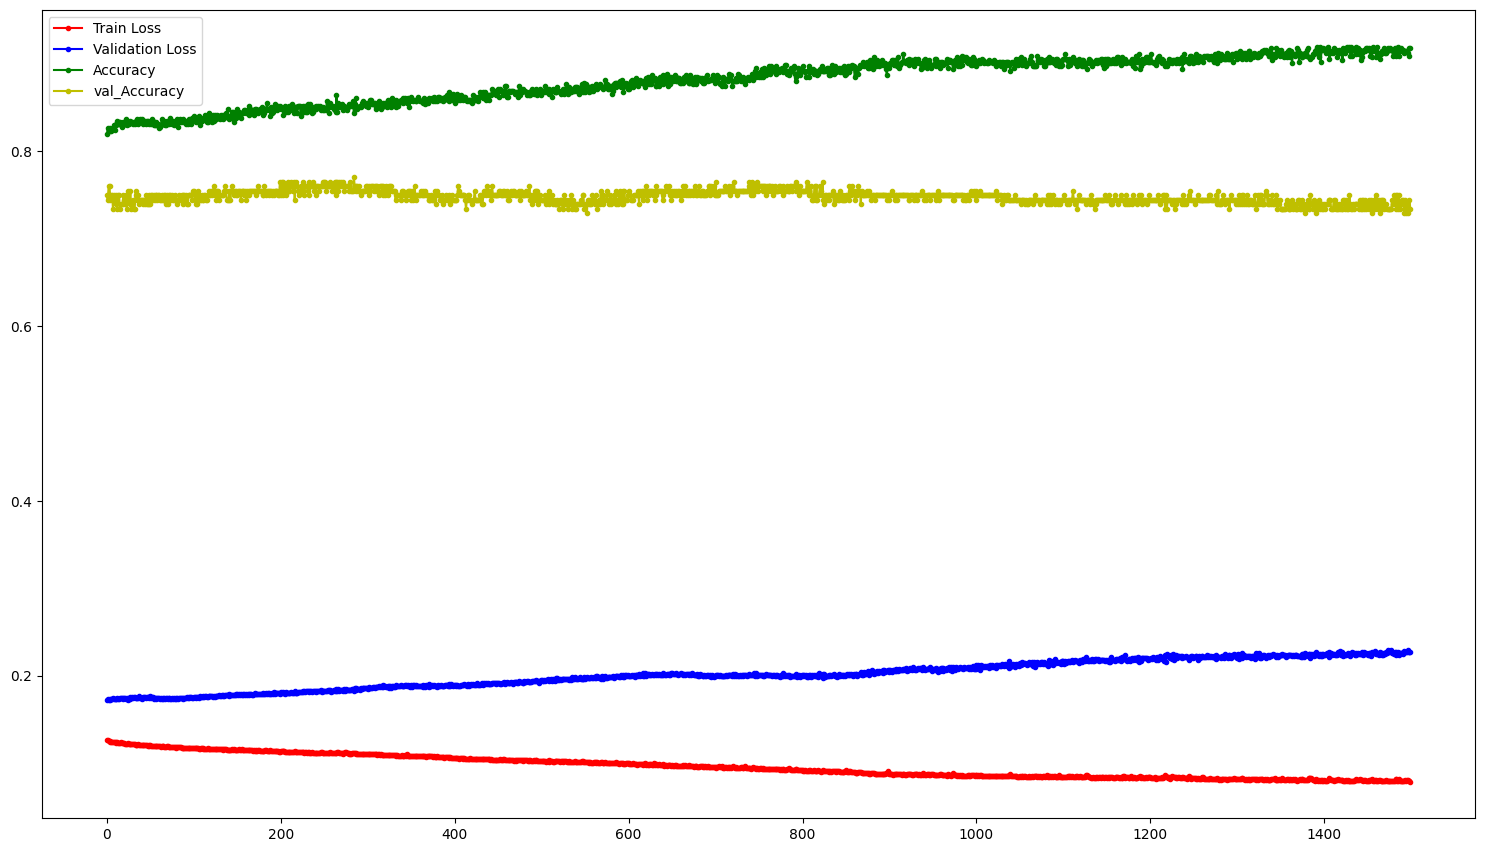

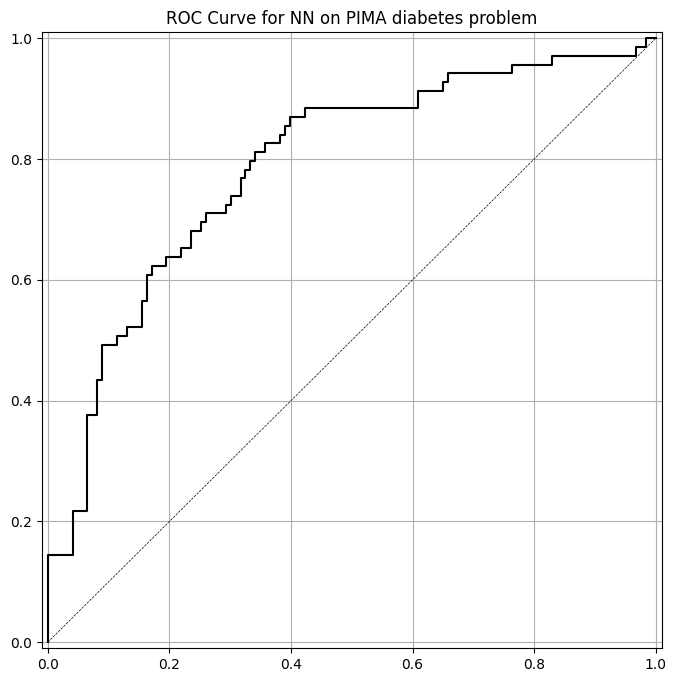

In [102]:
## usando taxa de aprendizado de .003 e treinando por 1500 epocas com o ADAM.
model_exercise.compile(Adam(learning_rate = 0.003), "mse", metrics=["accuracy"])
run_hist_ex = model_exercise.fit(X_train_norm_exercise, y_train, validation_data=(X_test_norm_exercise, y_test), epochs=1500)

y_pred_prob_nn_1_ex = model_exercise.predict(X_test_norm_exercise)
y_pred_class_nn_1_ex = (y_pred_prob_nn_1_ex > 0.5).astype("int32")
y_pred_class_nn_1_ex[:10]
y_pred_prob_nn_1_ex[:10]

plotarGraficos('estrutura SGD tx=0.003, 1500 epocas',run_hist_ex,y_pred_class_nn_1_ex,y_pred_prob_nn_1_ex)

Epoch 1/500
18/18 [==============================] - 0s 6ms/step - loss: 0.1558 - accuracy: 0.8247 - val_loss: 0.2476 - val_accuracy: 0.7344
Epoch 2/500
18/18 [==============================] - 0s 2ms/step - loss: 0.1886 - accuracy: 0.7917 - val_loss: 0.2415 - val_accuracy: 0.7344
Epoch 3/500
18/18 [==============================] - 0s 2ms/step - loss: 0.1826 - accuracy: 0.8021 - val_loss: 0.2376 - val_accuracy: 0.7500
Epoch 4/500
18/18 [==============================] - 0s 2ms/step - loss: 0.1791 - accuracy: 0.8021 - val_loss: 0.2364 - val_accuracy: 0.7500
Epoch 5/500
18/18 [==============================] - 0s 2ms/step - loss: 0.1929 - accuracy: 0.7934 - val_loss: 0.2363 - val_accuracy: 0.7552
Epoch 6/500
18/18 [==============================] - 0s 2ms/step - loss: 0.1794 - accuracy: 0.8056 - val_loss: 0.2421 - val_accuracy: 0.7500
Epoch 7/500
18/18 [==============================] - 0s 2ms/step - loss: 0.1818 - accuracy: 0.8090 - val_loss: 0.2361 - val_accuracy: 0.7500
Epoch 8/500
1

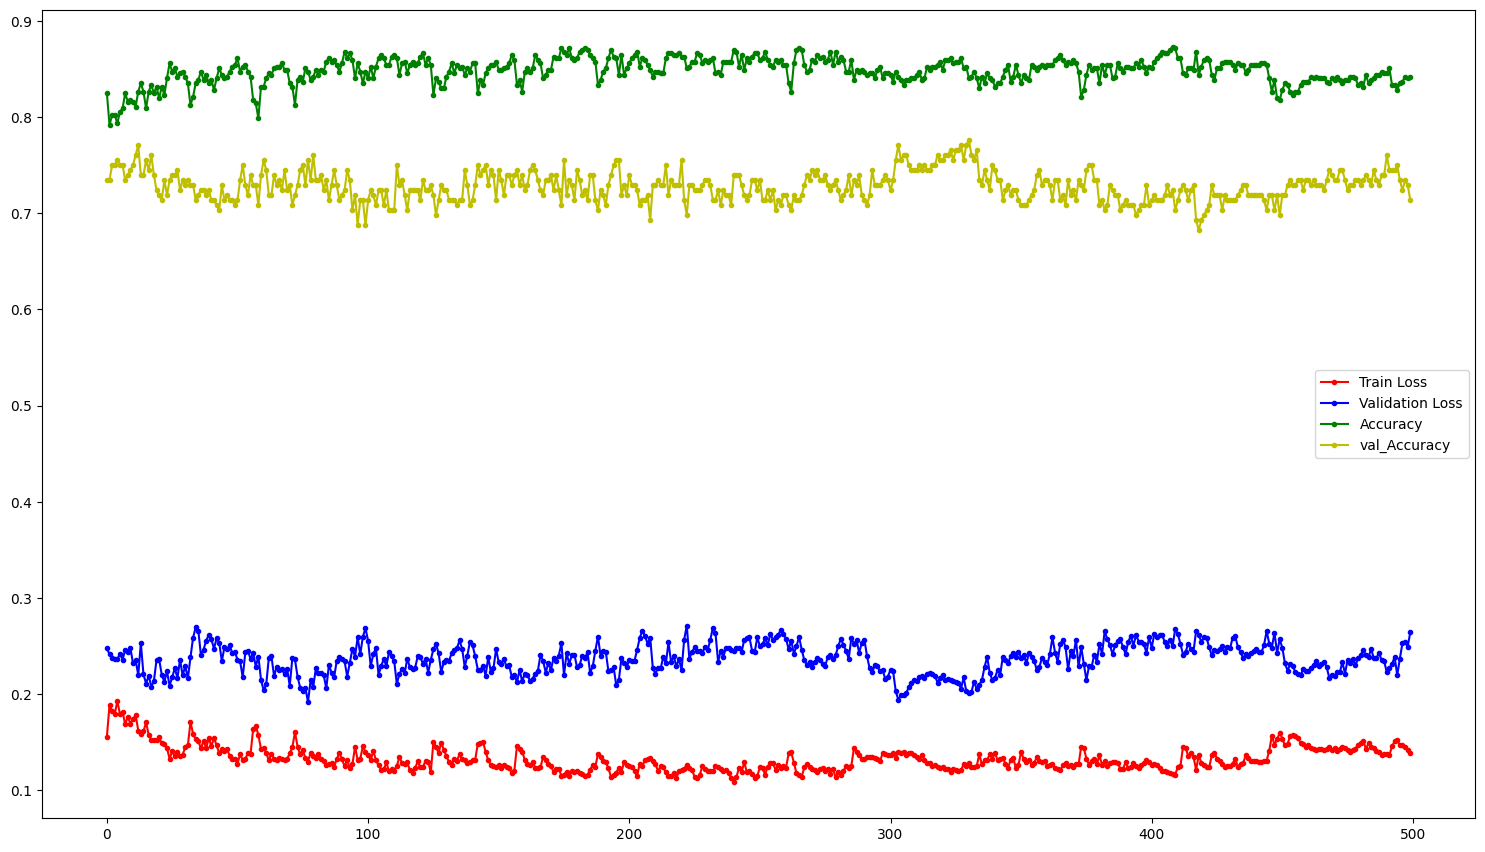

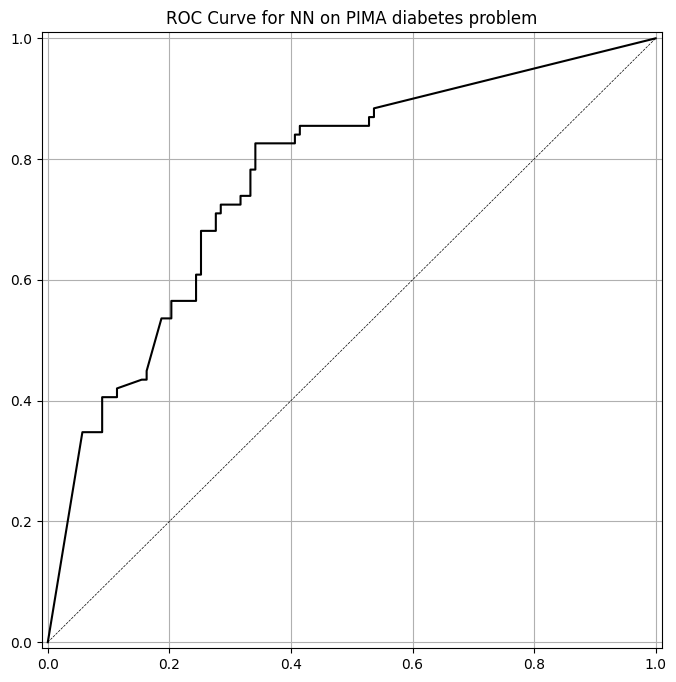

In [103]:
## usando taxa de aprendizado de .05 e treinando por 500 epocas com o ADAM.
model_exercise.compile(Adam(learning_rate = 0.05), "mse", metrics=["accuracy"])
run_hist_ex = model_exercise.fit(X_train_norm_exercise, y_train, validation_data=(X_test_norm_exercise, y_test), epochs=500)

y_pred_prob_nn_1_ex = model_exercise.predict(X_test_norm_exercise)
y_pred_class_nn_1_ex = (y_pred_prob_nn_1_ex > 0.5).astype("int32")
y_pred_class_nn_1_ex[:10]
y_pred_prob_nn_1_ex[:10]

plotarGraficos('estrutura SGD tx=0.003, 1500 epocas',run_hist_ex,y_pred_class_nn_1_ex,y_pred_prob_nn_1_ex)

Epoch 1/1500
18/18 [==============================] - 0s 7ms/step - loss: 0.1398 - accuracy: 0.8455 - val_loss: 0.2638 - val_accuracy: 0.7135
Epoch 2/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.1380 - accuracy: 0.8472 - val_loss: 0.2612 - val_accuracy: 0.7083
Epoch 3/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.1355 - accuracy: 0.8472 - val_loss: 0.2589 - val_accuracy: 0.7135
Epoch 4/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.1347 - accuracy: 0.8507 - val_loss: 0.2562 - val_accuracy: 0.7188
Epoch 5/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.1346 - accuracy: 0.8507 - val_loss: 0.2561 - val_accuracy: 0.7188
Epoch 6/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.1344 - accuracy: 0.8507 - val_loss: 0.2564 - val_accuracy: 0.7240
Epoch 7/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.1345 - accuracy: 0.8524 - val_loss: 0.2569 - val_accuracy: 0.7240
Epoch 

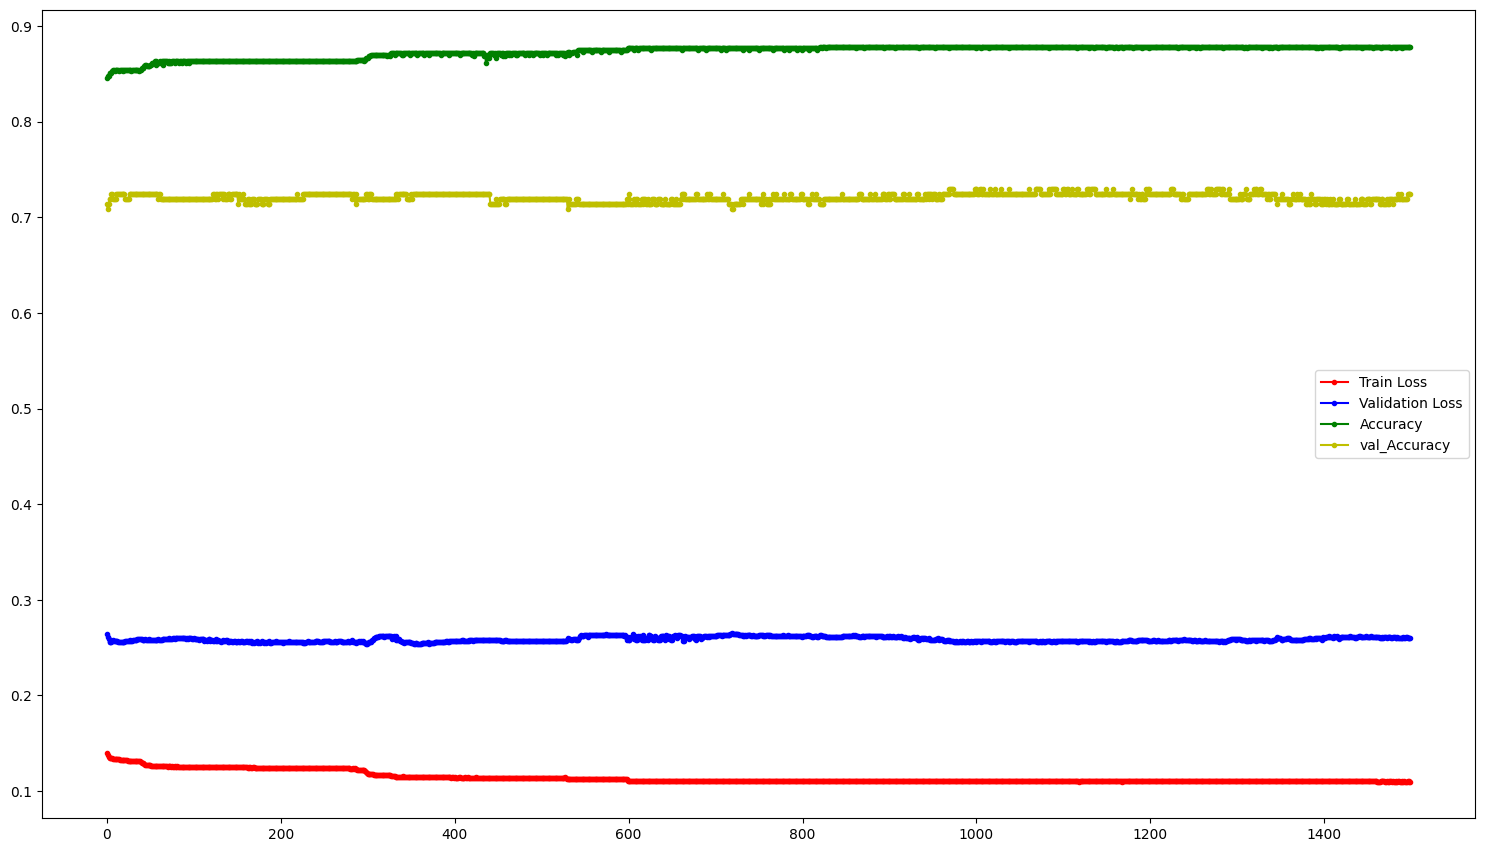

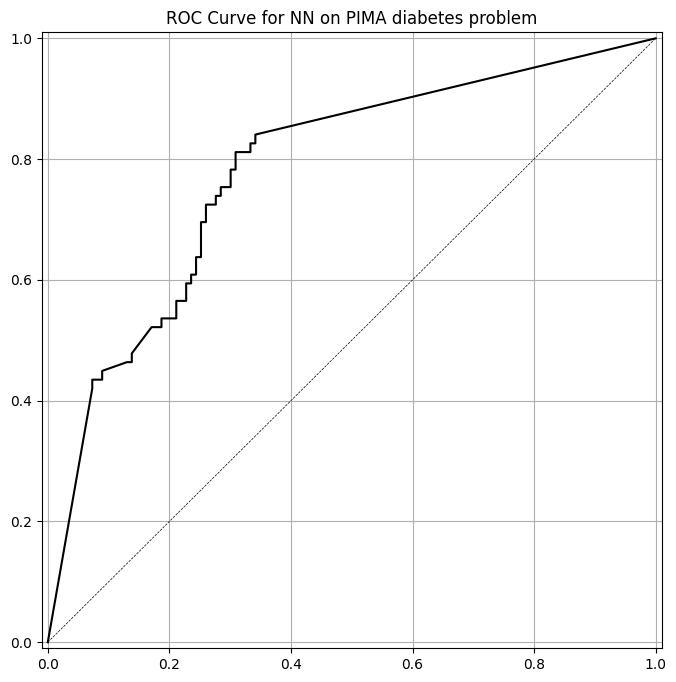

In [104]:
## usando taxa de aprendizado de .003 e treinando por 1500 epocas com o SGD.
model_exercise.compile(RMSprop(learning_rate = 0.003), "mse", metrics=["accuracy"])
run_hist_ex = model_exercise.fit(X_train_norm_exercise, y_train, validation_data=(X_test_norm_exercise, y_test), epochs=1500)

y_pred_prob_nn_1_ex = model_exercise.predict(X_test_norm_exercise)
y_pred_class_nn_1_ex = (y_pred_prob_nn_1_ex > 0.5).astype("int32")
y_pred_class_nn_1_ex[:10]
y_pred_prob_nn_1_ex[:10]

plotarGraficos('estrutura SGD tx=0.003, 1500 epocas',run_hist_ex,y_pred_class_nn_1_ex,y_pred_prob_nn_1_ex)

Epoch 1/500
18/18 [==============================] - 0s 6ms/step - loss: 0.1316 - accuracy: 0.8490 - val_loss: 0.2696 - val_accuracy: 0.7188
Epoch 2/500
18/18 [==============================] - 0s 2ms/step - loss: 0.1356 - accuracy: 0.8455 - val_loss: 0.2616 - val_accuracy: 0.7135
Epoch 3/500
18/18 [==============================] - 0s 2ms/step - loss: 0.1202 - accuracy: 0.8681 - val_loss: 0.2701 - val_accuracy: 0.7083
Epoch 4/500
18/18 [==============================] - 0s 2ms/step - loss: 0.1245 - accuracy: 0.8663 - val_loss: 0.2526 - val_accuracy: 0.7240
Epoch 5/500
18/18 [==============================] - 0s 2ms/step - loss: 0.1326 - accuracy: 0.8576 - val_loss: 0.2544 - val_accuracy: 0.7344
Epoch 6/500
18/18 [==============================] - 0s 3ms/step - loss: 0.1314 - accuracy: 0.8524 - val_loss: 0.2516 - val_accuracy: 0.7344
Epoch 7/500
18/18 [==============================] - 0s 2ms/step - loss: 0.1285 - accuracy: 0.8611 - val_loss: 0.2581 - val_accuracy: 0.7240
Epoch 8/500
1

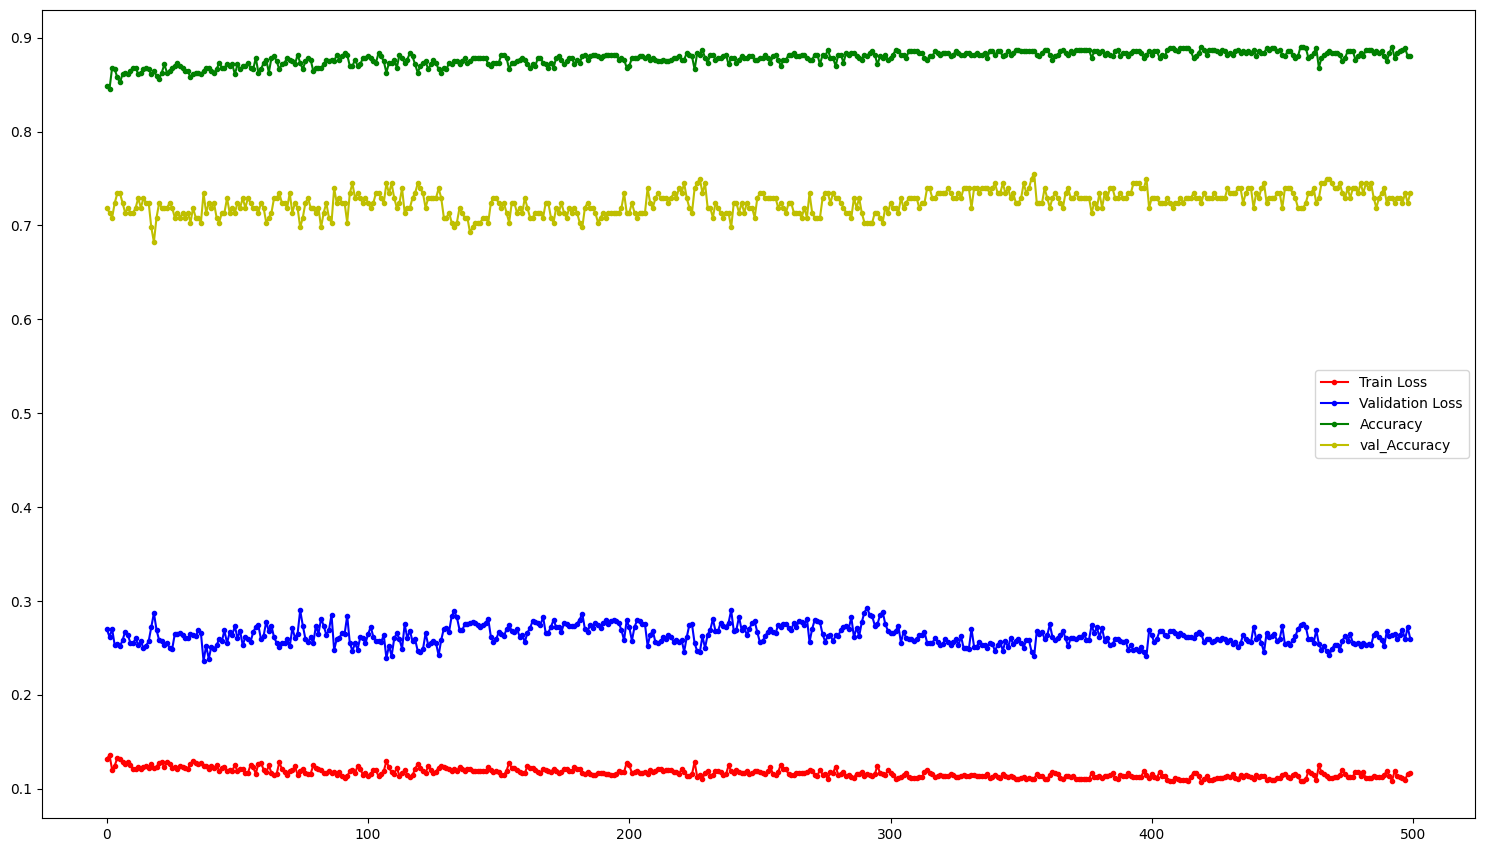

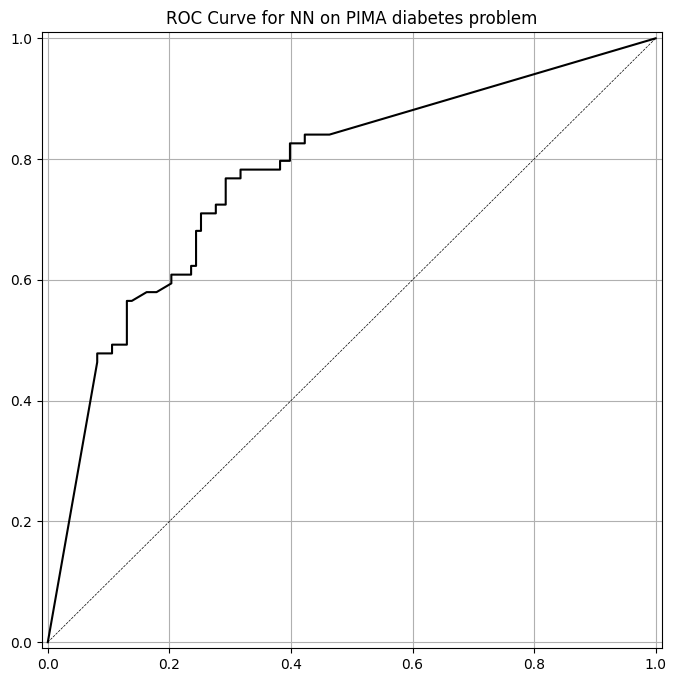

In [105]:
## usando taxa de aprendizado de .05 e treinando por 500 epocas com o SGD.
model_exercise.compile(RMSprop(learning_rate = 0.05), "mse", metrics=["accuracy"])
run_hist_ex = model_exercise.fit(X_train_norm_exercise, y_train, validation_data=(X_test_norm_exercise, y_test), epochs=500)

y_pred_prob_nn_1_ex = model_exercise.predict(X_test_norm_exercise)
y_pred_class_nn_1_ex = (y_pred_prob_nn_1_ex > 0.5).astype("int32")
y_pred_class_nn_1_ex[:10]
y_pred_prob_nn_1_ex[:10]

plotarGraficos('estrutura SGD tx=0.003, 1500 epocas',run_hist_ex,y_pred_class_nn_1_ex,y_pred_prob_nn_1_ex)

* SGD:

1500 it. e lr = 0.003 --> acc = 0.760 e auc = 0.823

500 it. e lr = 0.05 --> acc = 0.760 e auc = 0.807

* ADAM

1500 it. e lr = 0.003 --> acc = 0.734 e auc = 0.788

500 it. e lr = 0.05 --> acc = 0.714 e auc = 0.767

* RMSprop

1500 it. e lr = 0.003 --> acc = 0.724 e auc = 0.781

500 it. e lr = 0.05 --> acc = 0.734 e auc = 0.775


* Considerando os resultados obtidos, pode-se concluir que o melhor otimizador é o SGD, com 1500 iterações e lr = 0.003.
* Em todos os casos, ao diminuir o número de iterações, a acurácia e a AUC diminuem. Porém, essa diminuição não é tão significante, pois a maior diminuição foi de 2.3% na AUC
do SGD